In [1]:
import numpy as np
import os
import pulp as pl
import matplotlib.pyplot as plt
from matplotlib import cm

# Prehrana
## Modelska analiza 102

In [2]:
# data = np.loadtxt("tabela-zivil.dat", skiprows = 3, usecols=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10))

def get_data(fname):
    data = {}
    data_keys = ["energija", "mascobe", "OH", "proteini", "Ca", "Fe", "vitamin C", "K", "Na", "cena"]
    f = open(fname, "r")
    i = 0

    for line in f.readlines():
        if line[0] == "#":
            continue
        spl = line.split("\n")[0]
        spl = spl.split("\t")
        if "" in spl:
            spl.remove("")
        if "" in spl:
            spl.remove("")
        
        data[spl[0]] = {}
        for i in range(len(data_keys)):
            if i < 4 or i == 9:
                val = float(spl[i+1]) / 100
            elif i < 9:
                val = float(spl[i+1]) / 100 / 1000
            data[spl[0]][data_keys[i]]=val

    f.close()
    return data

def low_calorry_diet(data, limit=2000):
    data_keys = ["mascobe", "OH", "proteini", "Ca", "Fe", "vitamin C", "K", "Na", "cena"]
    min_intake = [70, 310, 50, 1, 0.018, 0.06, 3.5, 0.5]
    model = pl.LpProblem(f"Low calory {limit}", pl.LpMinimize)

    vars = {}

    for i in data.keys():
        vars[i] = pl.LpVariable(i, 0, None, pl.LpContinuous)

    cenovna = 0
    for i in vars.keys():
        cenovna += data[i]["energija"] * vars[i]

    model += cenovna
    for i, j in enumerate(data_keys[:-1]):
        sum_i = 0
        for name, var in vars.items():
            sum_i += var * data[name][j]
        model += sum_i >= min_intake[i]
        if j == "Na":
            model += sum_i <= 2.4

    for i in vars.keys():
        model += vars[i] <= limit

    
    model += sum((vars.values())) <= 2000
    model.solve()
    return model

def low_fat_diet(data, limit=2000):
    data_keys = ["energija", "OH", "proteini", "Ca", "Fe", "vitamin C", "K", "Na", "cena"]
    min_intake = [2000, 310, 50, 1, 0.018, 0.06, 3.5, 0.5]
    model = pl.LpProblem(f"Low fat {limit}", pl.LpMinimize)

    vars = {}

    for i in data.keys():
        vars[i] = pl.LpVariable(i, 0, None, pl.LpContinuous)
    
    cenovna = 0
    for i in vars.keys():
        cenovna += data[i]["mascobe"] * vars[i]
    
    model += cenovna
    for i, j in enumerate(data_keys[:-1]):
        sum_i = 0
        for name, var in vars.items():
            sum_i += var * data[name][j]
        model += sum_i >= min_intake[i]
        if j == "Na":
            model += sum_i <= 2.4

    for i in vars.keys():
        model += vars[i] <= limit
    
    
    model += sum((vars.values())) <= 2000
    model.solve()
    return model

def low_price_diet(data, limit=2000):
    data_keys = ["energija", "mascobe", "OH", "proteini", "Ca", "Fe", "vitamin C", "K", "Na", "cena"]
    min_intake = [2000, 70, 310, 50, 1, 0.018, 0.06, 3.5, 0.5]
    model = pl.LpProblem(f"Low price {limit}", pl.LpMinimize)

    vars = {}

    for i in data.keys():
        vars[i] = pl.LpVariable(i, 0, None, pl.LpContinuous)
    
    cenovna = 0
    for i in vars.keys():
        cenovna += data[i]["cena"] * vars[i]
    
    model += cenovna
    for i, j in enumerate(data_keys[:-1]):
        sum_i = 0
        for name, var in vars.items():
            sum_i += var * data[name][j]
        model += sum_i >= min_intake[i]
        if j == "Na":
            model += sum_i <= 2.4

    for i in vars.keys():
        model += vars[i] <= limit
    
    model += sum((vars.values())) <= 2000
    model.solve()
    return model

def varied_diet(data, energy, maxi):
    data_keys = ["energija", "OH", "proteini", "Ca", "Fe", "vitamin C", "K", "Na", "cena"]
    min_intake = [energy, 310, 50, 1, 0.018, 0.06, 3.5, 0.5]
    model = pl.LpProblem("Low fat", pl.LpMinimize)

    vars = {}

    for i in data.keys():
        vars[i] = pl.LpVariable(i, 0, None, pl.LpContinuous)
    
    cenovna = 0
    for i in vars.keys():
        cenovna += data[i]["mascobe"] * vars[i]
    model += cenovna
    for i in vars.values():
        model += i>=0
    for i in vars.keys():
        model += vars[i] <=maxi
    for i, j in enumerate(data_keys[:-1]):
        sum_i = 0
        for name, var in vars.items():
            sum_i += var * data[name][j]
        model += sum_i >= min_intake[i]
        if j == "Na":
            model += sum_i <= 2.4
    
    model += sum((vars.values())) <= 2000
    model.solve()
    return model

def view_optimization_vars(model):
    for v in model.variables():
        print(v.name, "=", v.varValue)

def plot(data, model, N, min_intake, title, mesojedec=False):
    norm = np.array([2000, 70, 310, 50, 1, 0.018, 0.06, 3.5, 0.5, 1])
    data_keys = (data["Pomaranca"]).keys()
    data_ticks = ["energija", "maščobe", "OH", "proteini", "Ca", "Fe", "vitamin C", "K", "Na", "cena [eur]"]
    all_intake = np.zeros(len(data_keys))
    bottom = np.zeros(len(data_keys))
    x = np.arange(len(data_keys))
    width=0.5
    cmap = plt.get_cmap('cool', N) #cm.winter(np.linspace(0, 1, N))
    plt.figure(figsize=[9, 5])

    j = 0
    for v in model.variables():
        one_intake = np.zeros(len(data_keys))
        if v.varValue == 0:
            continue
        # print(v.name, v.varValue)
        for i, key in enumerate(data_keys):
            new = data[v.name][key] * v.varValue
            all_intake[i] += new
            one_intake[i] = new
        plt.bar(x, one_intake/norm, width, bottom=bottom, label=v.name+r' $\times$ {} g'.format(round(v.varValue, 2)), color = cmap(j))
        j+=1
        bottom = np.copy(all_intake)/norm
    for j, y in enumerate(min_intake):
        if model.name == "Low_calory_2000" or model.name == 'Low_calory_300':
            plt.hlines(y/norm[j+1], xmin=j-width/2+1, xmax= j+width/2+1, linestyles="dotted", color = "black")

        elif model.name == 'Cukr_Low_calory':
            plt.hlines(y/norm[j+1], xmin=j-width/2+1, xmax= j+width/2+1, linestyles="dotted", color = "black")


        elif model.name == "Low_fat_2000" or  model.name == "Low_fat_300":
            if j == 0:
                plt.hlines(y/norm[j], xmin=j-width/2, xmax= j+width/2, linestyles="dotted", color = "black")
            else:
                plt.hlines(y/norm[j+1], xmin=j-width/2+1, xmax= j+width/2+1, linestyles="dotted", color = "black")

        elif model.name == "Low_price_2000" or model.name == "Low_price_200":
            plt.hlines(y/norm[j], xmin=j-width/2, xmax= j+width/2, linestyles="dotted", color = "black")

        elif model.name == "Gains_calory":
            plt.hlines(y/norm[j], xmin=j-width/2, xmax= j+width/2, linestyles="dotted", color = "black")

        elif model.name == 'LCHF_400':
            if j < 2:
                plt.hlines(y/norm[j], xmin=j-width/2, xmax= j+width/2, linestyles="dotted", color = "black")
            else:
                plt.hlines(y/norm[j+1], xmin=j-width/2+1, xmax= j+width/2+1, linestyles="dotted", color = "black")


    for i in range (len(all_intake)):
        plt.text(i, all_intake[i]/norm[i] + 0.1, str(round(all_intake[i]/norm[i], 2)), ha="center")
    plt.hlines(2.4/0.5, xmin=8-width/2, xmax= 8+width/2 , linestyles="-", color = "black", label="zgornja meja")

    #plt.yscale("log")
    plt.title(title, fontsize=18)
    plt.xticks(x, data_ticks)

    if mesojedec == False:
        plt.legend()
        plt.savefig('grafi/graf_'+model.name+'.pdf')

    elif mesojedec == True:
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
        plt.savefig('grafi/graf_'+model.name+'_mesojedec.pdf')
        
    plt.show()

c:\Users\lotri\AppData\Local\Programs\Python\Python310\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


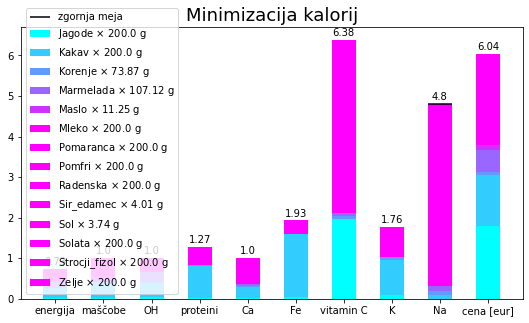

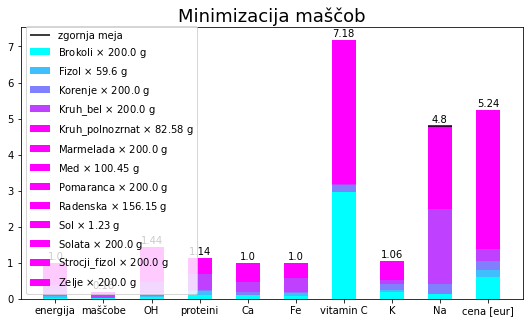

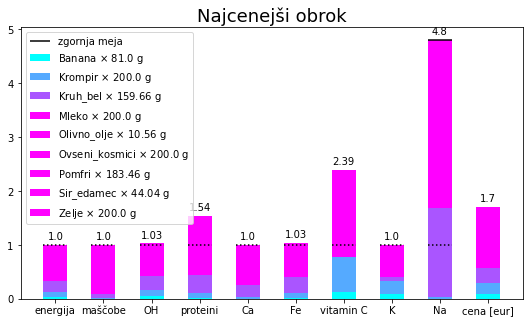

c:\Users\lotri\AppData\Local\Programs\Python\Python310\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


[[33. 23. 15. 13. 10.  8.  8.  8.  7.  7.]
 [33. 23. 15. 13. 10.  8.  8.  8.  7.  7.]
 [33. 23. 15. 13. 10.  8.  8.  8.  7.  7.]
 [33. 23. 15. 13. 10.  8.  8.  8.  7.  7.]
 [33. 23. 16. 14. 10.  9.  9.  7.  7.  7.]
 [35. 23. 15. 13. 10.  9.  9.  8.  7.  7.]
 [38. 23. 16. 13. 10.  9.  9.  8.  8.  8.]
 [39. 23. 16. 11. 10.  9.  9.  8.  8.  8.]
 [40. 21. 15. 12. 10.  9.  8.  8.  9.  8.]
 [41. 21. 15. 12. 10.  9.  8.  8.  8.  7.]
 [42. 21. 15. 12. 11.  8.  7.  7.  7.  7.]]


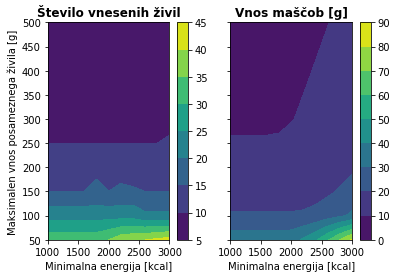

In [10]:
from locale import normalize

data = get_data("tabela-zivil.dat")

lim = 200
low_callory_model = low_calorry_diet(data, limit=lim)
low_fat_model = low_fat_diet(data, limit=lim)
low_price_model = low_price_diet(data, limit=lim)

min_intake = [70, 310, 50, 1, 0.018, 0.06, 3.5, 0.5]
plot(data, low_callory_model, 6, min_intake, 'Minimizacija kalorij')

min_intake = [2000, 310, 50, 1, 0.018, 0.06, 3.5, 0.5]
plot(data, low_fat_model, 5, min_intake, 'Minimizacija maščob')

min_intake = [2000, 70, 310, 50, 1, 0.018, 0.06, 3.5, 0.5]
plot(data, low_price_model, 4, min_intake, 'Najcenejši obrok')
maxi = np.arange(50, 550, 50)
energy = np.arange(1000, 3200, 200)

varied_model_num = np.zeros((len(energy), len(maxi)))
varied_model_obj = np.zeros((len(energy), len(maxi)))
for i in range(len(energy)):
    for j in range(len(maxi)):
        mod = varied_diet(data, energy[i], maxi[j])
        count = 0
        mas = 0
        for v in mod.variables():
            if v.varValue == 0:
                continue
            mas += v.varValue * data[v.name]['mascobe']
            count += 1
        varied_model_num[i, j] = count
        varied_model_obj[i, j] = mas
print(varied_model_num)
maxi, energy = np.meshgrid(maxi, energy)
fig, ax = plt.subplots(1, 2)
c1 = ax[0].contourf(energy, maxi, varied_model_num)
c2 = ax[1].contourf(energy, maxi, varied_model_obj)
ax[0].set_xlabel("Minimalna energija [kcal]")
ax[1].set_xlabel("Minimalna energija [kcal]")
ax[0].set_ylabel("Maksimalen vnos posameznega živila [g]")
ax[0].set_title("Število vnesenih živil", fontweight="bold")
ax[1].set_title("Vnos maščob [g]", fontweight="bold")
fig.colorbar(c1, ax=ax[0])
fig.colorbar(c2, ax=ax[1])


plt.setp(ax[1].get_yticklabels(), visible=False)
plt.show()

#view_optimization_vars(varied_model)

Ameriska_pica = 0.0
Banana = 0.0
Brokoli = 0.0
Cokolada = 0.0
Fizol = 0.0
Govedina = 0.0
Grozdje = 0.0
Jabolko = 0.0
Jagode = 0.0
Jajce = 0.0
Kakav = 0.0
Kokice = 0.0
Korenje = 0.0
Krompir = 0.0
Kruh_bel = 0.0
Kruh_polnozrnat = 0.0
Kumara = 0.0
Losos = 0.0
Makaroni = 0.0
Marmelada = 0.0
Maslo = 0.0
Med = 0.0
Mleko = 466.6687
Mortadela = 0.0
Nutella = 0.0
Olivno_olje = 7.8159154
Ovseni_kosmici = 761.2077
Paprika = 1.9626187
Paradiznik = 0.0
Piscanec = 0.0
Pivo = 0.0
Pomaranca = 0.0
Pomfri = 3.5559129
Postrv = 0.0
Puran = 0.0
Radenska = 0.0
Rdeca_pesa = 0.0
Riz = 0.0
Sir_edamec = 0.0
Skusa_soljena = 0.0
Sol = 0.0
Solata = 0.0
Strocji_fizol = 0.0
Svinjina = 0.0
Torta = 0.0
Tuna = 0.0
Vino_cabernet = 0.0
Vino_traminec = 0.0
Zelje = 152.85092


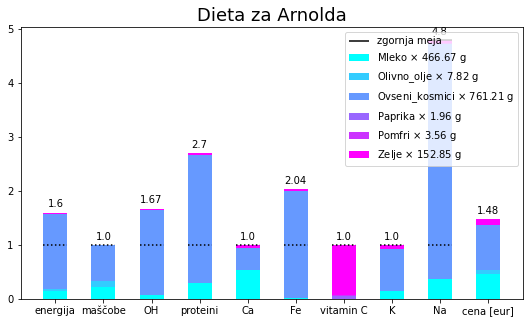

In [4]:
############## DODATNA MULTIOBJECTIVE LP #####################

def gains_diet(data):
    data_keys = ["energija", "mascobe", "OH", "proteini", "Ca", "Fe", "vitamin C", "K", "Na", "cena"]
    min_intake = [3200, 70, 310, 50, 1, 0.018, 0.06, 3.5, 0.5]
    model = pl.LpProblem("Gains_calory", pl.LpMinimize)

    vars = {}

    for i in data.keys():
        vars[i] = pl.LpVariable(i, 0, None, pl.LpContinuous)
    
    cenovna = 0
    for i in vars.keys():
        cenovna += data[i]["cena"] * vars[i]
    
    model += cenovna
    for i in vars.values():
        model += i>=0
    for i, j in enumerate(data_keys[:-1]):
        sum_i = 0
        for name, var in vars.items():
            sum_i += var * data[name][j]
        model += sum_i >= min_intake[i]
        if j == "Na":
            model += sum_i <= 2.4
    model += sum((vars.values())) <= 5000
    
    model.solve()

    # First solve:
    obj = pl.value(model.objective)

    model = pl.LpProblem("Gains_calory", pl.LpMaximize)
    vars = {}

    for i in data.keys():
        vars[i] = pl.LpVariable(i, 0, None, pl.LpContinuous)
    
    cenovna = 0
    for i in vars.keys():
        cenovna += data[i]["energija"] * vars[i]
    
    model += cenovna
    for i in vars.values():
        model += i>=0
    for i, j in enumerate(data_keys[1:-1]):
        sum_i = 0
        for name, var in vars.items():
            sum_i += var * data[name][j]
        model += sum_i >= min_intake[i+1]
        if j == "Na":
            model += sum_i <= 2.4
    sum_i = 0
    for i in vars.keys():
        sum_i += vars[i]*data[i]["cena"]
    model += sum_i <= obj
    model += sum((vars.values())) <= 5000
    model.solve()

    return model

def gains_diet2(data, alpha):
    data_keys = ["energija", "mascobe", "OH", "proteini", "Ca", "Fe", "vitamin C", "K", "Na", "cena"]
    min_intake = [500, 70, 310, 50, 1, 0.018, 0.06, 3.5, 0.5]
    model = pl.LpProblem("Gains_calory", pl.LpMinimize)

    vars = {}

    for i in data.keys():
        vars[i] = pl.LpVariable(i, 0, None, pl.LpContinuous)
    
    cenovna = 0
    for i in vars.keys():
        cenovna = cenovna + alpha * data[i]["cena"] * vars[i] - (1 - alpha) * data[i]["energija"] * vars[i]
    
    model += cenovna
    for i in vars.values():
        model += i>=0
    for i, j in enumerate(data_keys[1:-1]):
        sum_i = 0
        for name, var in vars.items():
            sum_i += var * data[name][j]
        model += sum_i >= min_intake[i+1]
        if j == "Na":
            model += sum_i <= 2.4
    
    model += sum((vars.values())) <= 10000
    model.solve()

    return model

gains_model = gains_diet(data)

view_optimization_vars(gains_model)
plot(data, gains_model, 6, [2000, 70, 310, 50, 1, 0.018, 0.06, 3.5, 0.5], "Dieta za Arnolda")

20


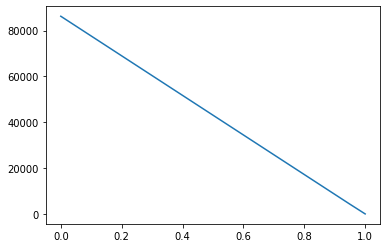

Ameriska_pica = 0.0
Banana = 0.0
Brokoli = 0.0
Cokolada = 538.87124
Fizol = 0.0
Govedina = 0.0
Grozdje = 0.0
Jabolko = 0.0
Jagode = 0.0
Jajce = 0.0
Kakav = 21.278702
Kokice = 0.0
Korenje = 0.0
Krompir = 0.0
Kruh_bel = 0.0
Kruh_polnozrnat = 0.0
Kumara = 0.0
Losos = 0.0
Makaroni = 0.0
Marmelada = 0.0
Maslo = 0.0
Med = 0.0
Mleko = 0.0
Mortadela = 0.0
Nutella = 0.0
Olivno_olje = 9406.6948
Ovseni_kosmici = 0.0
Paprika = 32.697548
Paradiznik = 0.0
Piscanec = 0.0
Pivo = 0.0
Pomaranca = 0.0
Pomfri = 0.0
Postrv = 0.0
Puran = 0.0
Radenska = 0.0
Rdeca_pesa = 0.0
Riz = 0.0
Sir_edamec = 0.0
Skusa_soljena = 0.0
Sol = 0.45774944
Solata = 0.0
Strocji_fizol = 0.0
Svinjina = 0.0
Torta = 0.0
Tuna = 0.0
Vino_cabernet = 0.0
Vino_traminec = 0.0
Zelje = 0.0


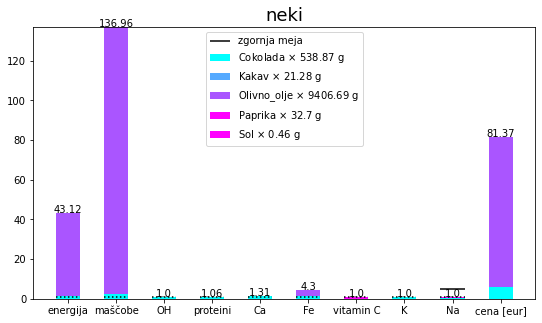

In [5]:
alpha = np.arange(0, 1.05, 0.05)
# print(alpha[19])
objs = np.zeros(len(alpha))
for i in range(len(alpha)):
    gains_model_2 = gains_diet2(data, alpha[i])
    objs[i] = pl.value(gains_model_2.objective)

plt.plot(alpha, np.abs(objs))
print(np.argmin(np.abs(objs)))
plt.show()

gains_model_2 = gains_diet2(data, alpha[19])
view_optimization_vars(gains_model_2)
plot(data, gains_model_2, 4, min_intake, "neki")

c:\Users\lotri\AppData\Local\Programs\Python\Python310\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Ameriska_pica = 0.0
Banana = 0.0
Brokoli = 0.0
Cokolada = 0.0
Fizol = 0.0
Govedina = 0.0
Grozdje = 0.0
Jabolko = 0.0
Jagode = 0.0
Jajce = 0.0
Kakav = 433.54842
Kokice = 0.0
Korenje = 0.0
Krompir = 0.0
Kruh_bel = 0.0
Kruh_polnozrnat = 0.0
Kumara = 0.0
Losos = 0.0
Makaroni = 0.0
Marmelada = 0.0
Maslo = 0.0
Med = 50.0
Mleko = 0.0
Mortadela = 0.0
Nutella = 0.0
Olivno_olje = 0.0
Ovseni_kosmici = 0.0
Paprika = 3.8047713
Paradiznik = 0.0
Piscanec = 0.0
Pivo = 0.0
Pomaranca = 0.0
Pomfri = 80.433654
Postrv = 0.0
Puran = 0.0
Radenska = 956.26853
Rdeca_pesa = 0.0
Riz = 0.0
Sir_edamec = 0.0
Skusa_soljena = 0.0
Sol = 4.0253317
Solata = 471.9193
Strocji_fizol = 0.0
Svinjina = 0.0
Torta = 0.0
Tuna = 0.0
Vino_cabernet = 0.0
Vino_traminec = 0.0
Zelje = 0.0


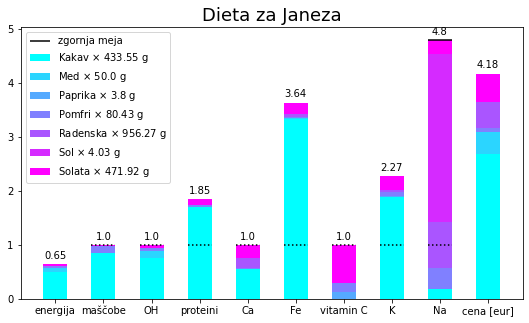

In [6]:
########### DODATNA SLADKOSNEDI ############

def sweet_diet(data):
    data_keys = ["mascobe", "OH", "proteini", "Ca", "Fe", "vitamin C", "K", "Na", "cena"]
    min_intake = [70, 310, 50, 1, 0.018, 0.06, 3.5, 0.5]
    model = pl.LpProblem("Cukr Low calory", pl.LpMinimize)

    vars = {}

    for i in data.keys():
        vars[i] = pl.LpVariable(i, 0, None, pl.LpContinuous)

    cenovna = 0
    for i in vars.keys():
        cenovna += data[i]["energija"] * vars[i]

    model += cenovna
    for i, j in enumerate(data_keys[:-1]):
        sum_i = 0
        for name, var in vars.items():
            sum_i += var * data[name][j]
        model += sum_i >= min_intake[i]
        if j == "Na":
            model += sum_i <= 2.4
    model += vars["Med"] >= 50
    
    model += sum((vars.values())) <= 2000
    model.solve()
    return model

sweet_model = sweet_diet(data)

view_optimization_vars(sweet_model)
plot(data, sweet_model, 7, [70, 310, 50, 1, 0.018, 0.06, 3.5, 0.5], "Dieta za Janeza")

c:\Users\lotri\AppData\Local\Programs\Python\Python310\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


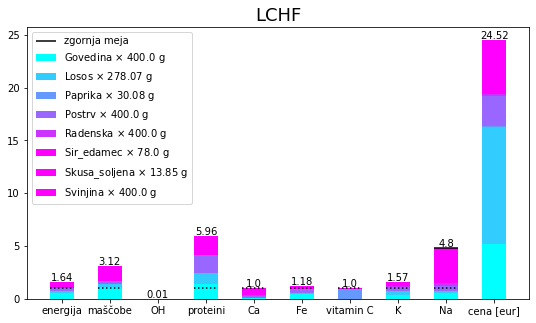

In [7]:
########### Dieta LCHF ###########

def low_CH_high_fat_diet(data, limit=2000):
    data_keys = ["energija", "mascobe", "proteini", "Ca", "Fe", "vitamin C", "K", "Na", "cena"]
    min_intake = [2000, 70, 50, 1, 0.018, 0.06, 3.5, 0.5]
    model = pl.LpProblem(f"LCHF {limit}", pl.LpMinimize)

    vars = {}

    for i in data.keys():
        vars[i] = pl.LpVariable(i, 0, None, pl.LpContinuous)
    
    cenovna = 0
    for i in vars.keys():
        cenovna += data[i]["OH"] * vars[i]
    
    model += cenovna
    for i, j in enumerate(data_keys[:-1]):
        sum_i = 0
        for name, var in vars.items():
            sum_i += var * data[name][j]
        model += sum_i >= min_intake[i]
        if j == "Na":
            model += sum_i <= 2.4

    for i in vars.keys():
        model += vars[i] <= limit
    
    
    model += sum((vars.values())) <= 2000
    model.solve()
    return model

LCHF_model = low_CH_high_fat_diet(data, limit=400)

min_intake = [2000, 70, 50, 1, 0.018, 0.06, 3.5, 0.5]
plot(data, LCHF_model, 6, min_intake, 'LCHF')

### Analiza živil

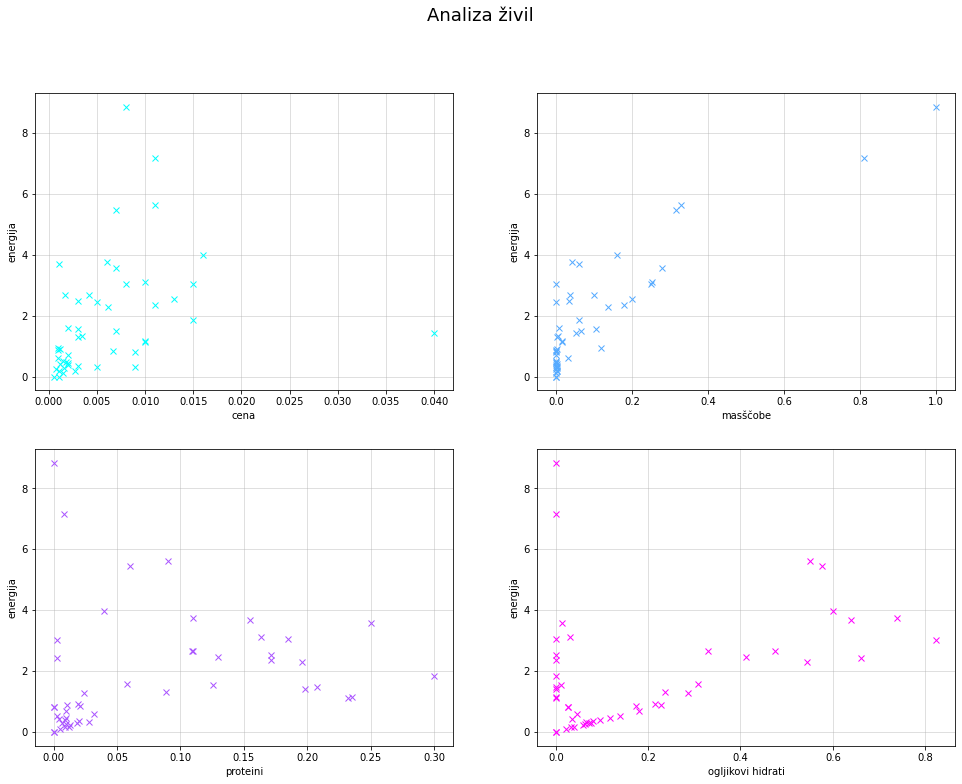

In [8]:
data = get_data('tabela-zivil.dat')

energija = np.zeros(49)
cena = np.zeros(49)
mascoba = np.zeros(49)
proteini = np.zeros(49)
oh = np.zeros(49)

i = 0
for key in data.keys():
    energija[i] = data[key]['energija']
    cena[i] = data[key]['cena']
    mascoba[i] = data[key]['mascobe']
    proteini[i] = data[key]['proteini']
    oh[i] = data[key]['OH']

    i += 1
    
cmap=plt.get_cmap('cool', 4)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16.5, 12), sharex=False)

axes[0, 0].plot(cena, energija, linestyle='', marker='x', color=cmap(0))
axes[0, 1].plot(mascoba, energija, linestyle='', marker='x', color=cmap(1))
axes[1, 0].plot(proteini, energija, linestyle='', marker='x', color=cmap(2))
axes[1, 1].plot(oh, energija, linestyle='', marker='x', color=cmap(3))

axes[0, 0].set_ylabel('energija')
axes[0, 1].set_ylabel('energija')
axes[1, 0].set_ylabel('energija')
axes[1, 1].set_ylabel('energija')

axes[0, 0].set_xlabel('cena')
axes[0, 1].set_xlabel('masščobe')
axes[1, 0].set_xlabel('proteini')
axes[1, 1].set_xlabel('ogljikovi hidrati')

axes[0, 0].grid(alpha=0.5)
axes[0, 1].grid(alpha=0.5)
axes[1, 0].grid(alpha=0.5)
axes[1, 1].grid(alpha=0.5)

fig.suptitle('Analiza živil', fontsize=18)
plt.savefig('grafi/analiza_zivil.pdf')
plt.show()

### Mesojedec


c:\Users\lotri\AppData\Local\Programs\Python\Python310\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


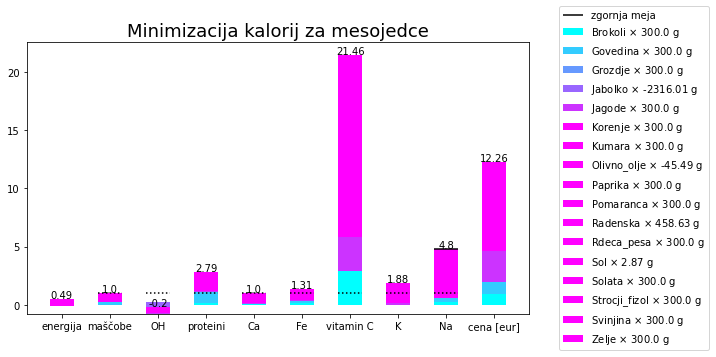

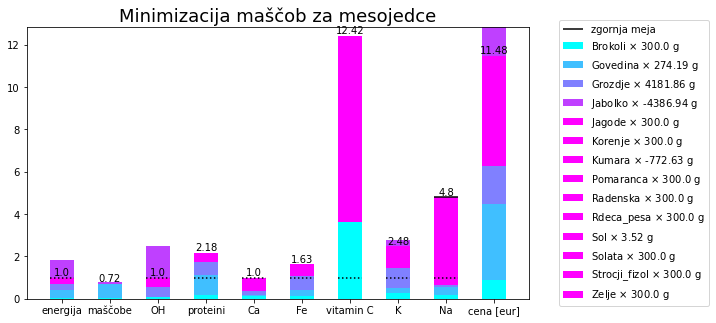

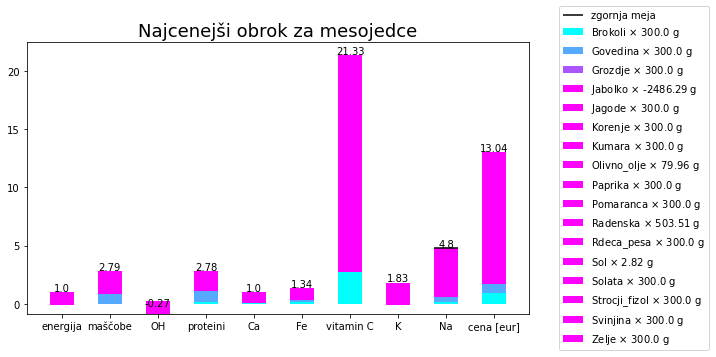

In [9]:
def get_data_meso(fname):
    meso = ['Govedina', 'Svinjina', 'Jabolko', 'Rdeca_pesa', 'Solata', 'Zelje', 'Grozdje', 'Jagode', 'Brokoli', 'Paradiznik', 'Paprika', 'Korenje', 'Strocji_fizol', 'Kumara', 'Pomaranca', 'Olivno_olje', 'Sol', 'Radenska', 'Vino_cabernet', 'Vino_traminec']

    data = {}
    data_keys = ["energija", "mascobe", "OH", "proteini", "Ca", "Fe", "vitamin C", "K", "Na", "cena"]
    f = open(fname, "r")
    i = 0

    for line in f.readlines():
        if line[0] == "#":
            continue
        spl = line.split("\n")[0]
        spl = spl.split("\t")
        if "" in spl:
            spl.remove("")
        if "" in spl:
            spl.remove("")
        
        data[spl[0]] = {}
        for i in range(len(data_keys)):
            if i < 4 or i == 9:
                val = float(spl[i+1]) / 100
            elif i < 9:
                val = float(spl[i+1]) / 100 / 1000

            if spl[0] in meso:
                data[spl[0]][data_keys[i]]=val
            elif spl[0] not in meso:
                data[spl[0]][data_keys[i]]=0

    f.close()
    return data


data_m = get_data_meso('tabela-zivil.dat')

# for key in data_m.keys():
#     print(key)
#     print(data_m[key])



lim = 300
low_callory_model_m = low_calorry_diet(data_m, limit=lim)
low_fat_model_m = low_fat_diet(data_m, limit=lim)
low_price_model_m = low_price_diet(data_m, limit=lim)

min_intake = [70, 310, 50, 1, 0.018, 0.06, 3.5, 0.5]
plot(data_m, low_callory_model_m, 6, min_intake, 'Minimizacija kalorij za mesojedce', mesojedec=True)

min_intake = [2000, 310, 50, 1, 0.018, 0.06, 3.5, 0.5]
plot(data_m, low_fat_model_m, 5, min_intake, 'Minimizacija maščob za mesojedce', mesojedec=True)

min_intake = [2000, 70, 310, 50, 1, 0.018, 0.06, 3.5, 0.5]
plot(data, low_price_model_m, 4, min_intake, 'Najcenejši obrok za mesojedce', mesojedec=True)
maxi = np.arange(50, 550, 50)
energy = np.arange(1000, 3200, 200)